# Adding features - final dataframe
For the most common words there are far more mentions than job posts. Certain keywords are mentioned multiple times in a post. This will skew the results. We need to search each post to see if the keyword is present and return true or false. The assumption being that if a keyword is mentioned in a job post. That is a desired skill.
- Search each post and create dataframe 
- Calculate percentage of posts for each keyword

In [2]:
import numpy as np
import pandas as pd 
import re  
import popular_data_skills.utils.keywords as kws
import popular_data_skills.config.config as config


First lets get the keywords and keyword groups

In [3]:
keywords = kws.Keywords()
keywords.read_file(config.KEYWORDS)

keyword_groups =  kws.Keywords()
keyword_groups.read_file(config.KEYWORD_GROUPS)

Next we will get the dataframe

In [4]:
df = pd.read_csv(config.WRANGLED_DATA_FILE)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_title              593 non-null    object 
 1   company_name           591 non-null    object 
 2   location               593 non-null    object 
 3   date_posted            593 non-null    object 
 4   applicant_count        480 non-null    float64
 5   job_description_lines  592 non-null    object 
 6   country                593 non-null    object 
 7   job                    593 non-null    object 
 8   experience             309 non-null    float64
dtypes: float64(2), object(7)
memory usage: 41.8+ KB


In [5]:
# Drop na lines from job description column
df.dropna(subset=['job_description_lines'], inplace=True)

## Search each post and create dataframe 
Now we will create a dataframe identifing if a post has a keyword or not. We will use a regex expression to search for each keyword and their related similiar words in each post. 
- First we need to add spaces either side of each keyword to ensure we search for just that words and not part of another words. r being the best example. 
- Next we will group each keyword and it's related similar words into one expression with an or operator 
- Finally we will search if each job description contains any of these keywords and record the results in a data frame.
- 

In [6]:
# Add spaces to either side of the word
def add_spaces(keyword_dict: dict):
    """Adds one space either side of every string in a dict of lists. 

    Args:
        keyword_dict (dict): _description_

    Returns:
        spaced_kewords (dict): _description_
    """
    spaced_keywords={}
    for key, word_list in keyword_dict.dict.items():
        # Add spaces in keyword 
        spaced_key = key.center(len(key)+2)
        spaced_words_list=[]
        for word in word_list:
            # Add spaces to each similar word
            spaced_word = word.center(len(word)+2)
            spaced_words_list.append(spaced_word )
        spaced_keywords[spaced_key] = spaced_words_list
    return spaced_keywords
        
spaced_keywords = add_spaces(keywords)


In [7]:
# Create df from dict of keywords and similar words 
df_from_dict = pd.DataFrame()

for new_keyword, similar_words in spaced_keywords.items():
    if len(similar_words) > 0:
        pattern = '|'.join(similar_words)
        pattern = pattern +'|'+ new_keyword
    else:
        pattern = new_keyword
    df_from_dict[new_keyword] = df['job_description_lines'].str.contains(pattern, regex=True)
    df_from_dict[new_keyword] = df_from_dict[new_keyword].astype(int)

df_from_dict.head()

,a/b,advertising,architecture,automation,aws,azure,bash,bayesian,c,c#,...,bachelor degree,any degree,power bi,problem solving,decision trees,random forest,structured data,relational data,unstructured data,unsupervised learning
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [8]:
# Merge from_dict_df and df to get a complete df we can save and use fro further analysis
final_df = pd.merge(df, df_from_dict, left_index=True, right_index=True )
# strip trailing and leading whitespace used in regex patterns
final_df.columns = final_df.columns.str.strip()
final_df

,job_title,company_name,location,date_posted,applicant_count,job_description_lines,country,job,experience,a/b,...,bachelor degree,any degree,power bi,problem solving,decision trees,random forest,structured data,relational data,unstructured data,unsupervised learning
0,data engineer / machine learning engineer,streamba,glasgow scotland united kingdom,1 month ago,7.0,\n as a data engineer / machine l...,uk,scientist,NaN,0,...,0,1,0,0,0,0,0,0,0,0
1,data analyst support scientist – remote genomi...,hireresources,santa ana ca,3 days ago,5.0,\none of our valued clients a leading and grow...,usa,scientist,2.0,0,...,0,1,0,1,0,0,0,0,0,0
2,data scientist remote,yelp,glasgow scotland united kingdom,4 days ago,116.0,\n at yelp it’s our mission to co...,uk,scientist,2.0,0,...,0,0,0,0,0,0,0,0,0,0
3,data scientist - growth,spotify,london england united kingdom,2 weeks ago,NaN,\n the freemium r&d team oversees...,uk,scientist,3.0,1,...,0,1,1,0,0,0,0,0,0,0
4,data scientist - growth strategy,spotify,london england united kingdom,2 weeks ago,NaN,\n are you a talented data scient...,uk,scientist,3.0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,analytics developer,dice,united states,28 minutes ago,11.0,\n dice is the leading career des...,usa,analyst,3.0,0,...,0,1,1,0,0,0,0,0,0,0
589,data engineer analystics remote,koch industries,dallas tx,1 week ago,9.0,\ndescription\n\nsentient energy www.sentient-...,usa,analyst,2.0,0,...,0,1,1,0,0,0,0,1,0,0
590,digital analyst - data specialist,ambit consulting services,san francisco ca,2 months ago,10.0,\n acs is a consulting firm focus...,usa,analyst,2.0,0,...,0,1,1,0,0,0,0,1,0,0
591,data analyst ii risk adjustment,boston medical center healthnet plan/well sens...,boston ma,6 hours ago,4.0,\n finance / accounting\n\nremote...,usa,analyst,NaN,0,...,0,1,0,0,0,0,0,0,0,0


## Adding degree column
To make the dataframe easier to filter we will add a degree level column. Stating the level of degree asked if any.   
We will also group the experience into groups rather than individual years

In [9]:
def add_degree(row):
    if row['phd'] == 1:
        return 'phd'
    elif row['masters degree'] == 1:
        return 'ms'
    elif row['bachelor degree'] == 1:
        return 'bs'
    elif row['any degree'] == 1:
        return 'any'
    else:
        return 'not specified'

final_df['degree_level'] = final_df.apply(add_degree, axis=1 )
final_df

,job_title,company_name,location,date_posted,applicant_count,job_description_lines,country,job,experience,a/b,...,any degree,power bi,problem solving,decision trees,random forest,structured data,relational data,unstructured data,unsupervised learning,degree_level
0,data engineer / machine learning engineer,streamba,glasgow scotland united kingdom,1 month ago,7.0,\n as a data engineer / machine l...,uk,scientist,NaN,0,...,1,0,0,0,0,0,0,0,0,any
1,data analyst support scientist – remote genomi...,hireresources,santa ana ca,3 days ago,5.0,\none of our valued clients a leading and grow...,usa,scientist,2.0,0,...,1,0,1,0,0,0,0,0,0,phd
2,data scientist remote,yelp,glasgow scotland united kingdom,4 days ago,116.0,\n at yelp it’s our mission to co...,uk,scientist,2.0,0,...,0,0,0,0,0,0,0,0,0,not specified
3,data scientist - growth,spotify,london england united kingdom,2 weeks ago,NaN,\n the freemium r&d team oversees...,uk,scientist,3.0,1,...,1,1,0,0,0,0,0,0,0,any
4,data scientist - growth strategy,spotify,london england united kingdom,2 weeks ago,NaN,\n are you a talented data scient...,uk,scientist,3.0,0,...,0,1,0,1,0,0,0,0,0,not specified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,analytics developer,dice,united states,28 minutes ago,11.0,\n dice is the leading career des...,usa,analyst,3.0,0,...,1,1,0,0,0,0,0,0,0,any
589,data engineer analystics remote,koch industries,dallas tx,1 week ago,9.0,\ndescription\n\nsentient energy www.sentient-...,usa,analyst,2.0,0,...,1,1,0,0,0,0,1,0,0,any
590,digital analyst - data specialist,ambit consulting services,san francisco ca,2 months ago,10.0,\n acs is a consulting firm focus...,usa,analyst,2.0,0,...,1,1,0,0,0,0,1,0,0,any
591,data analyst ii risk adjustment,boston medical center healthnet plan/well sens...,boston ma,6 hours ago,4.0,\n finance / accounting\n\nremote...,usa,analyst,NaN,0,...,1,0,0,0,0,0,0,0,0,ms


## Grouping Experience

In [10]:
def group_experience(row):
    if row['experience'] == 0:
        return '0'
    elif row['experience'] == 1:
        return '1'
    elif row['experience'] == 2:
        return '2'
    elif (row['experience'] >= 3) & (row['experience'] < 5):
        return '3-5'
    elif row['experience'] >= 5:
        return '5+'
    else:
        return '0'

final_df['experience'] = final_df.apply(group_experience, axis=1 )
final_df

,job_title,company_name,location,date_posted,applicant_count,job_description_lines,country,job,experience,a/b,...,any degree,power bi,problem solving,decision trees,random forest,structured data,relational data,unstructured data,unsupervised learning,degree_level
0,data engineer / machine learning engineer,streamba,glasgow scotland united kingdom,1 month ago,7.0,\n as a data engineer / machine l...,uk,scientist,0,0,...,1,0,0,0,0,0,0,0,0,any
1,data analyst support scientist – remote genomi...,hireresources,santa ana ca,3 days ago,5.0,\none of our valued clients a leading and grow...,usa,scientist,2,0,...,1,0,1,0,0,0,0,0,0,phd
2,data scientist remote,yelp,glasgow scotland united kingdom,4 days ago,116.0,\n at yelp it’s our mission to co...,uk,scientist,2,0,...,0,0,0,0,0,0,0,0,0,not specified
3,data scientist - growth,spotify,london england united kingdom,2 weeks ago,NaN,\n the freemium r&d team oversees...,uk,scientist,3-5,1,...,1,1,0,0,0,0,0,0,0,any
4,data scientist - growth strategy,spotify,london england united kingdom,2 weeks ago,NaN,\n are you a talented data scient...,uk,scientist,3-5,0,...,0,1,0,1,0,0,0,0,0,not specified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,analytics developer,dice,united states,28 minutes ago,11.0,\n dice is the leading career des...,usa,analyst,3-5,0,...,1,1,0,0,0,0,0,0,0,any
589,data engineer analystics remote,koch industries,dallas tx,1 week ago,9.0,\ndescription\n\nsentient energy www.sentient-...,usa,analyst,2,0,...,1,1,0,0,0,0,1,0,0,any
590,digital analyst - data specialist,ambit consulting services,san francisco ca,2 months ago,10.0,\n acs is a consulting firm focus...,usa,analyst,2,0,...,1,1,0,0,0,0,1,0,0,any
591,data analyst ii risk adjustment,boston medical center healthnet plan/well sens...,boston ma,6 hours ago,4.0,\n finance / accounting\n\nremote...,usa,analyst,0,0,...,1,0,0,0,0,0,0,0,0,ms


In [11]:
final_df.to_csv(config.FINAL_DATA_FILE, index=False)

## Calculate percentage of posts for each keyword

We will now calcualte the percentage of post that contain each keyword. We can show results in groups to better compare keywords. 

In [12]:
# Drop non numeric columns 
numeric_df = final_df.drop(['job_title', 'company_name', 'location', 	'date_posted', 	'applicant_count', 	'job_description_lines',	'country',	'job',	'experience', 'degree_level'], axis=1)

skill_counts = numeric_df.sum()
skill_counts.sort_values(ascending=False, inplace=True)
total_posts = len(df)
pct_skills = round((skill_counts / total_posts) *100, 0)


In [13]:
# importing the required library
import numpy as np
import matplotlib.pyplot as plt

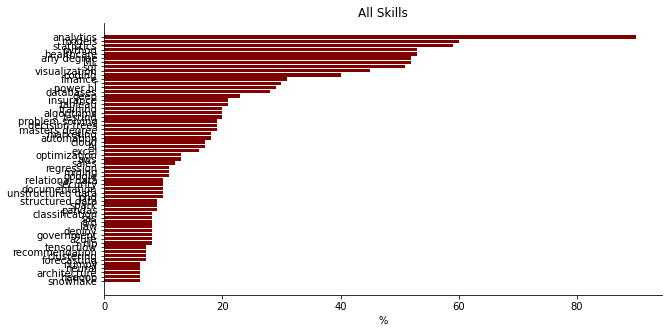

analytics          90.0
models             60.0
statistics         59.0
python             53.0
healthcare         53.0
any degree         52.0
ML                 52.0
sql                51.0
visualization      45.0
coding             40.0
finance            31.0
r                  30.0
power bi           29.0
databases          28.0
deep               23.0
insurance          21.0
tableau            21.0
training           20.0
algorithms         20.0
testing            20.0
problem solving    19.0
decision trees     19.0
masters degree     19.0
marketing          18.0
automation         18.0
cloud              17.0
AI                 17.0
excel              16.0
optimization       13.0
aws                13.0
dtype: float64

In [23]:
def barchart(data, title):
    # creating the dataset
    x = list(data.index)
    y = list(data.values)
    
    fig = plt.figure(figsize = (10, 5))
    ax = fig.gca()  
    # Creating the bar plot
    ax.barh(x, y, color ='maroon',)
    
    # plt.xlabel("Courses offered")
    # plt.ylabel("No. of students enrolled")
    # plt.title("Students enrolled in different courses")
    # plt.xticks(rotation=70)
    ax.spines[["top", "right"]].set_visible(False)
    plt.xlabel('%')
    plt.title(title)
    ax.invert_yaxis()
    plt.show()

top_skills = pct_skills[(pct_skills >5) & (pct_skills <100)]
barchart(top_skills, 'All Skills')
pct_skills.head(30)

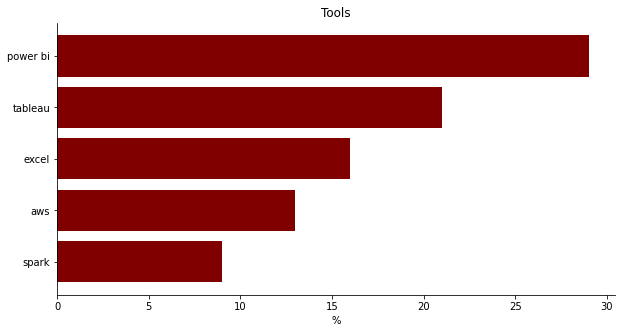

In [140]:
in_demand_tools = pct_skills[pct_skills.index.isin(keyword_groups.dict['Tools'])]
in_demand_tools.head(5)
barchart(in_demand_tools, 'Tools')


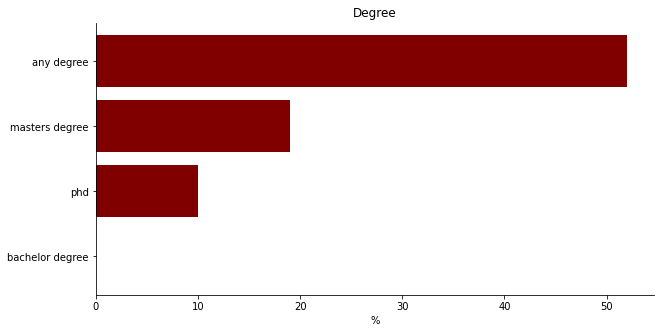

In [141]:
in_demand_degree = pct_skills[pct_skills.index.isin(keyword_groups.dict['Degree'])]
in_demand_degree
barchart(in_demand_degree, 'Degree')

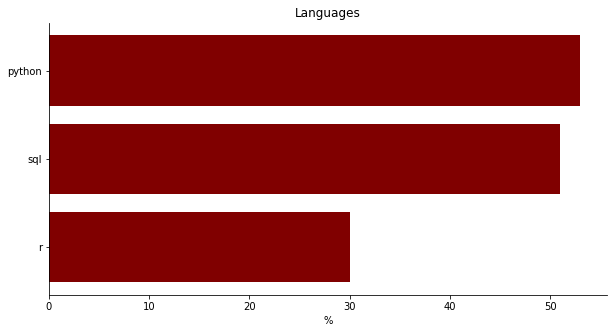

In [151]:
in_demand_languages = pct_skills[pct_skills.index.isin(keyword_groups.dict['Languages'])]
barchart(in_demand_languages, 'Languages')

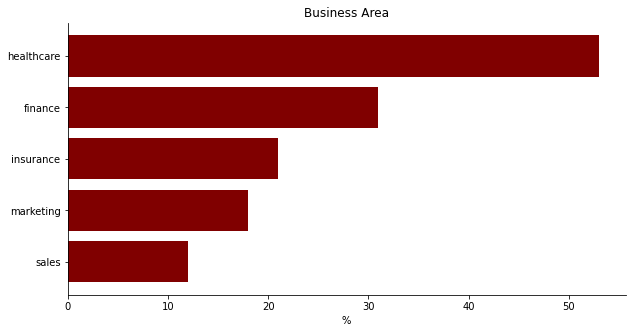

In [146]:
in_demand_business = pct_skills[pct_skills.index.isin(keyword_groups.dict['Business_area'])]
barchart(in_demand_business, 'Business Area')

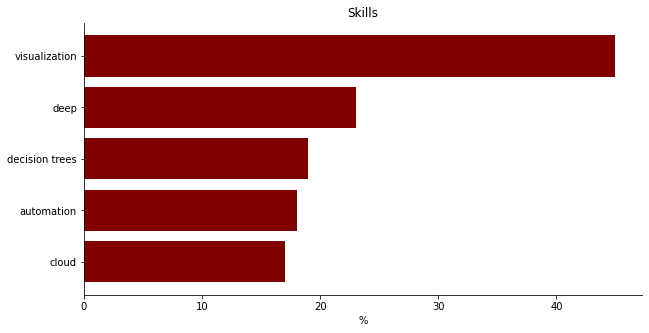

In [152]:
in_demand_skills = pct_skills[pct_skills.index.isin(keyword_groups.dict['Skills'])]
barchart(in_demand_skills, 'Skills')

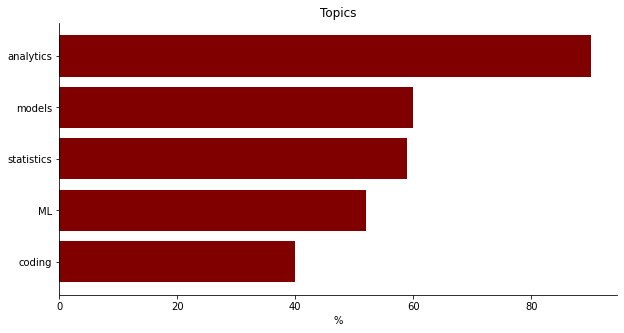

In [153]:
in_demand_subjects = pct_skills[pct_skills.index.isin(keyword_groups.dict['Topic'])]
barchart(in_demand_subjects, 'Topics')

There we have the percentage of posts that ask for each keyword. Next we will make this data frame filterable to use in a dashboard to better visualise our findings. 

There are still some refinements we could make in the future. power bi and microsoft suite as well as google suite may need looking into. We could possible group than together into suites.
search terms might be throwing false positives and may need some looking into. bi, c, decision may need another word in the search term to narrow down the keyword. 
terms may be able to be grouped together like relational and structued data. 